#### DTW Lib


In [1]:
import numpy as np
from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



Step pattern recursion:
 g[i,j] = min(
     g[i-3,j-2] +     d[i-2,j-1] +     d[i-1,j  ] +     d[i  ,j  ] ,
     g[i-1,j-1] +     d[i  ,j  ] ,
     g[i-2,j-3] +     d[i-1,j-2] +     d[i  ,j-1] + 0 * d[i  ,j  ] ,
 ) 

Normalization hint: N



/home/slime/Workspace/Vietnamese-Alphabet-Pronunciation/.venv/lib/python3.10/site-packages/dtw/stepPattern.py:341: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(-x[ss, 1], -x[ss, 2], 'o', color="black", marker="o", fillstyle="none")


<Axes: xlabel='Query index', ylabel='Reference index'>

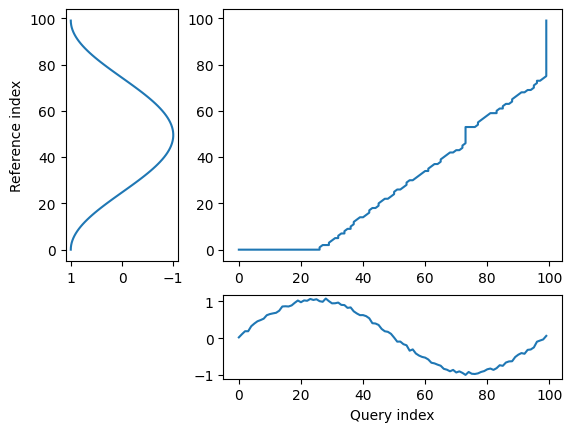

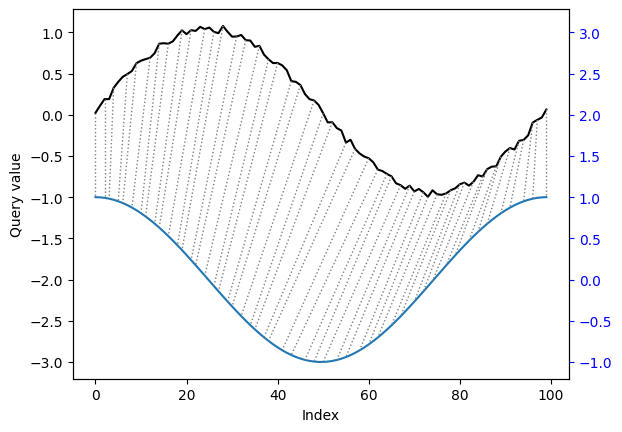

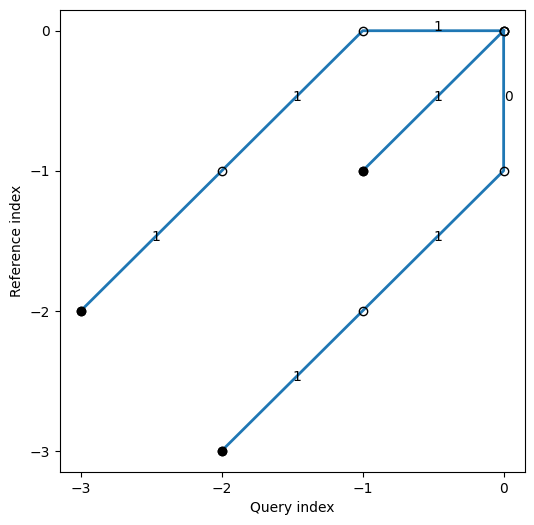

In [2]:
idx = np.linspace(0, 6.28, num=100)
query = np.sin(idx) + np.random.uniform(size=100) / 10.0
template = np.cos(idx)

alignment = dtw(query, template, keep_internals=True)
alignment.plot(type="threeway")

dtw(
    query, template, keep_internals=True, step_pattern=rabinerJuangStepPattern(6, "c")
).plot(type="twoway", offset=-2)

## See the recursion relation, as formula and diagram
print(rabinerJuangStepPattern(6, "c"))
rabinerJuangStepPattern(6, "c").plot()

### Dynamic time warping


In [3]:
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as dist

In [4]:
# DTW function
def dp(dist_mat):
    N, M = dist_mat.shape

    # Initialize the cost matrix
    cost_mat = np.zeros((N + 1, M + 1))
    for i in range(1, N + 1):
        cost_mat[i, 0] = np.inf
    for i in range(1, M + 1):
        cost_mat[0, i] = np.inf

    # Fill the cost matrix while keeping traceback information
    traceback_mat = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            penalty = [
                cost_mat[i, j],  # match (0)
                cost_mat[i, j + 1],  # insertion (1)
                cost_mat[i + 1, j],
            ]  # deletion (2)
            i_penalty = np.argmin(penalty)
            cost_mat[i + 1, j + 1] = dist_mat[i, j] + penalty[i_penalty]
            traceback_mat[i, j] = i_penalty

    # Traceback from bottom right
    i = N - 1
    j = M - 1
    path = [(i, j)]
    while i > 0 or j > 0:
        tb_type = traceback_mat[i, j]
        if tb_type == 0:
            # Match
            i = i - 1
            j = j - 1
        elif tb_type == 1:
            # Insertion
            i = i - 1
        elif tb_type == 2:
            # Deletion
            j = j - 1
        path.append((i, j))

    # Strip infinity edges from cost_mat before returning
    cost_mat = cost_mat[1:, 1:]
    return (path[::-1], cost_mat)

#### Univariate example


Alignment cost: 0.0000
Normalized alignment cost: 0.0000


(np.float64(-0.25), np.float64(5.25), np.float64(-0.8500000000000001), np.float64(6.85))

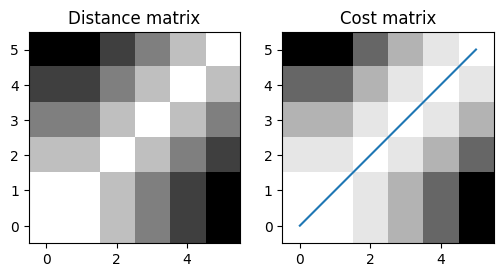

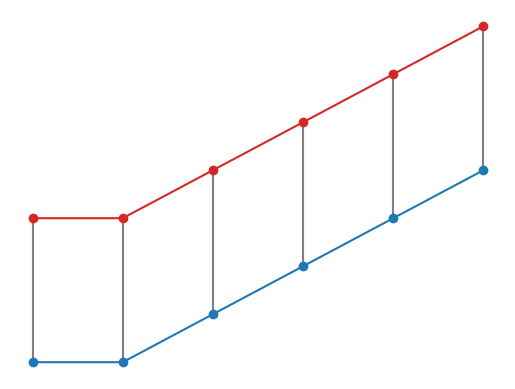

In [5]:
x = np.array([1, 1, 2, 3, 4, 5])
y = np.array([1, 1, 2, 3, 4, 5])
# distance matrix
N = x.shape[0]
M = y.shape[0]
dist_mat = np.zeros((N, M))
for i in range(N):
    for j in range(M):
        dist_mat[i, j] = abs(x[i] - y[j])

# dtw
path, cost_mat = dp(dist_mat)
print("Alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]))
print("Normalized alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1] / (N + M)))

plt.figure(figsize=(6, 4))
plt.subplot(121)
plt.title("Distance matrix")
plt.imshow(dist_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
plt.subplot(122)
plt.title("Cost matrix")
plt.imshow(cost_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_path, y_path = zip(*path)
plt.plot(y_path, x_path)

plt.figure()
for x_i, y_j in path:
    plt.plot([x_i, y_j], [x[x_i] + 1.5, y[y_j] - 1.5], c="C7")
plt.plot(np.arange(x.shape[0]), x + 1.5, "-o", c="C3")
plt.plot(np.arange(y.shape[0]), y - 1.5, "-o", c="C0")
plt.axis("off")

### Preprocessing audio


In [6]:
from scipy.io import wavfile
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

#### Load audio


In [7]:
standard_audio = "../dataset/old/i_standard.wav"
ipd.Audio(standard_audio)

<IPython.lib.display.Audio object>

In [8]:
high_audio = "../dataset/old/i_high.wav"
ipd.Audio(high_audio)

<IPython.lib.display.Audio object>

In [9]:
low_audio = "../dataset/old/i_low.wav"
ipd.Audio(low_audio)

<IPython.lib.display.Audio object>

In [10]:
wrong_audio = "../dataset/old/i_wrong(a).wav"
ipd.Audio(wrong_audio)

<IPython.lib.display.Audio object>

In [11]:
signal_standard, sr_standard = librosa.load(standard_audio)
signal_high, sr_high = librosa.load(high_audio)
signal_low, sr_low = librosa.load(low_audio)
signal_wrong, sr_wrong = librosa.load(wrong_audio)

In [12]:
signal_standard.shape, signal_high.shape, signal_low.shape, signal_wrong.shape

((55930,), (55930,), (57340,), (50290,))

In [13]:
### processing
sample_duration = 1 / sr_standard
print(f"One sample lasts for {sample_duration:6f} seconds")

One sample lasts for 0.000045 seconds


In [14]:
tot_sample = len(signal_standard)
tot_sample

55930

In [15]:
duration = 1 / sr_standard * tot_sample
print(f"The audio lasts for {duration} seconds")

The audio lasts for 2.5365079365079364 seconds


#### Visualize audio signal in the time domain


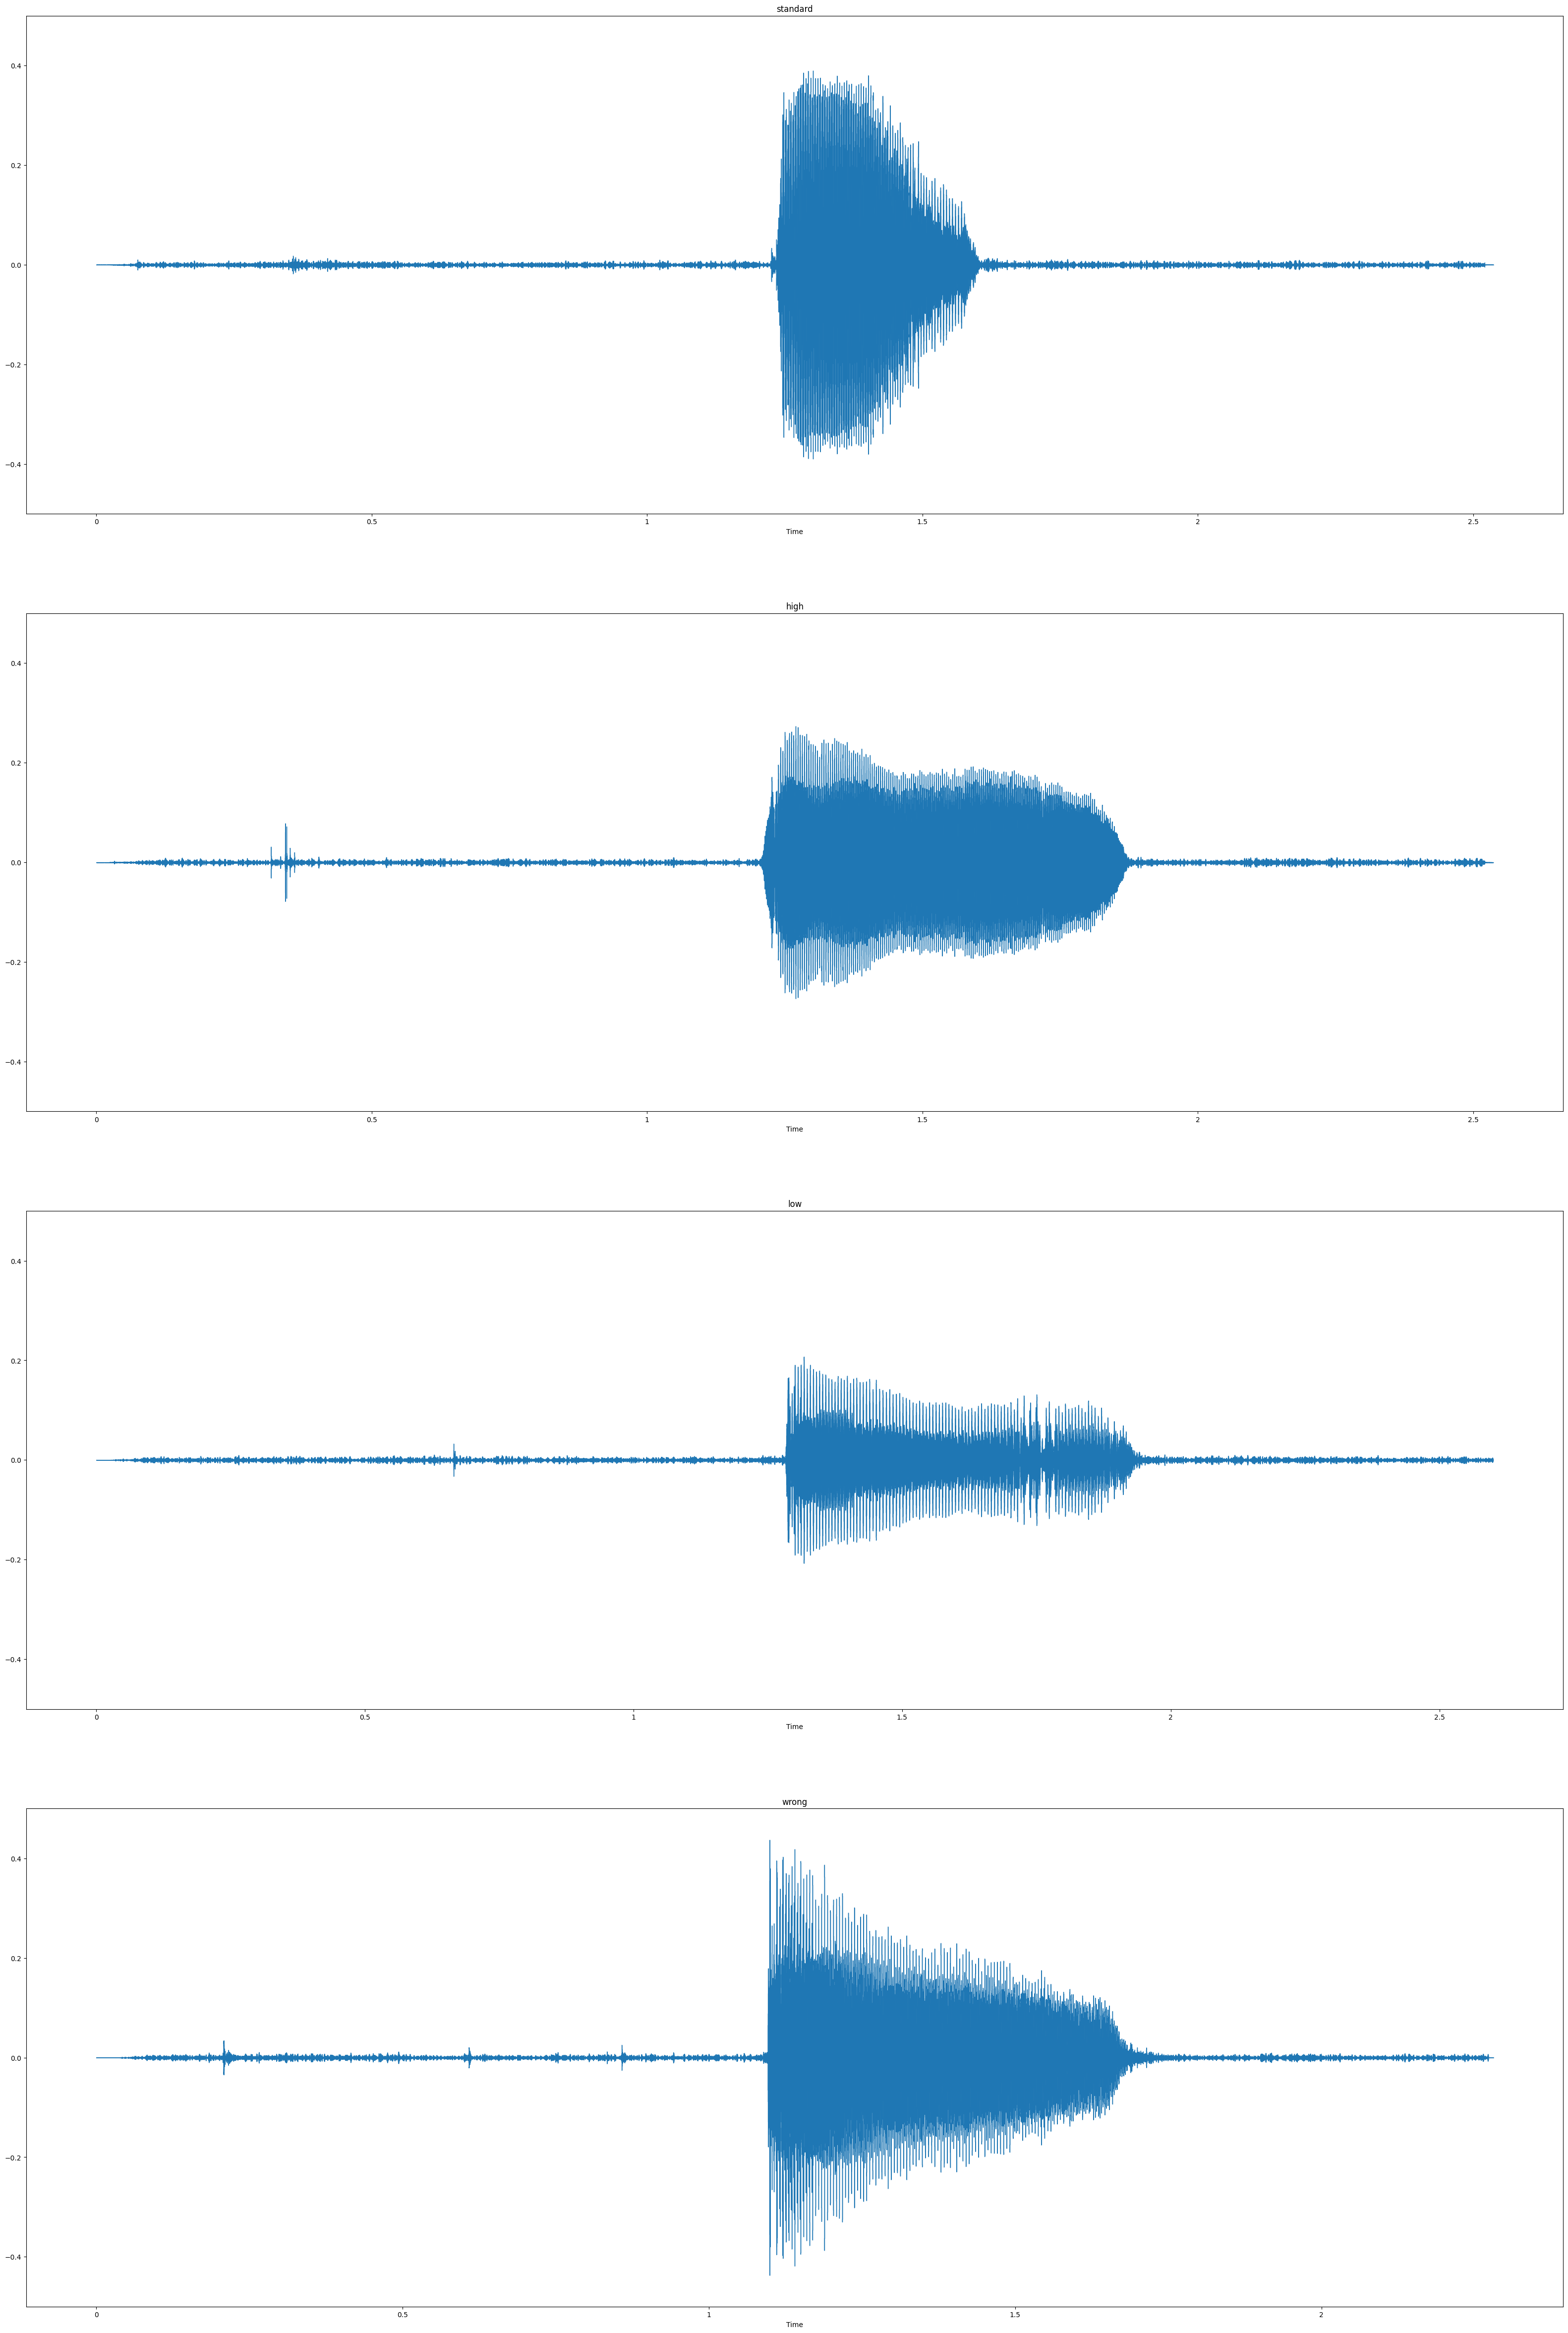

In [16]:
plt.figure(figsize=(40, 60))

plt.subplot(4, 1, 1)
librosa.display.waveshow(signal_standard)
plt.ylim((-0.5, 0.5))
plt.title("standard")

plt.subplot(4, 1, 2)
librosa.display.waveshow(signal_high)
plt.ylim((-0.5, 0.5))
plt.title("high")

plt.subplot(4, 1, 3)
librosa.display.waveshow(signal_low)
plt.ylim((-0.5, 0.5))
plt.title("low")

plt.subplot(4, 1, 4)
librosa.display.waveshow(signal_wrong)
plt.ylim((-0.5, 0.5))
plt.title("wrong")

plt.show()

#### Caculating amplitude envelope


In [17]:
FRAME_SIZE = 1024
HOP_LENGTH = 512


def amplitude_envelope(signal, frame_size, hop_length):
    """Calculate the amplitude envelope of a signal with a given frame size nad hop length."""
    amplitude_envelope = []

    # calculate amplitude envelope for each frame
    for i in range(0, len(signal), hop_length):
        amplitude_envelope_current_frame = max(signal[i : i + frame_size])
        amplitude_envelope.append(amplitude_envelope_current_frame)

    return np.array(amplitude_envelope)

In [18]:
def fancy_amplitude_envelope(signal, frame_size, hop_length):
    """Fancier Python code to calculate the amplitude envelope of a signal with a given frame size."""
    return np.array(
        [max(signal[i : i + frame_size]) for i in range(0, len(signal), hop_length)]
    )

In [19]:
# number of frames in amplitude envelope
ae_standard = amplitude_envelope(signal_standard, FRAME_SIZE, HOP_LENGTH)
ae_high = amplitude_envelope(signal_high, FRAME_SIZE, HOP_LENGTH)
ae_low = amplitude_envelope(signal_low, FRAME_SIZE, HOP_LENGTH)
ae_wrong = amplitude_envelope(signal_wrong, FRAME_SIZE, HOP_LENGTH)
len(ae_standard)


110

#### Visualizing amplitude envelop


In [20]:
frames = range(len(ae_standard))
t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)
rms_standard = librosa.feature.rms(
    y=signal_standard, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH
)[0]

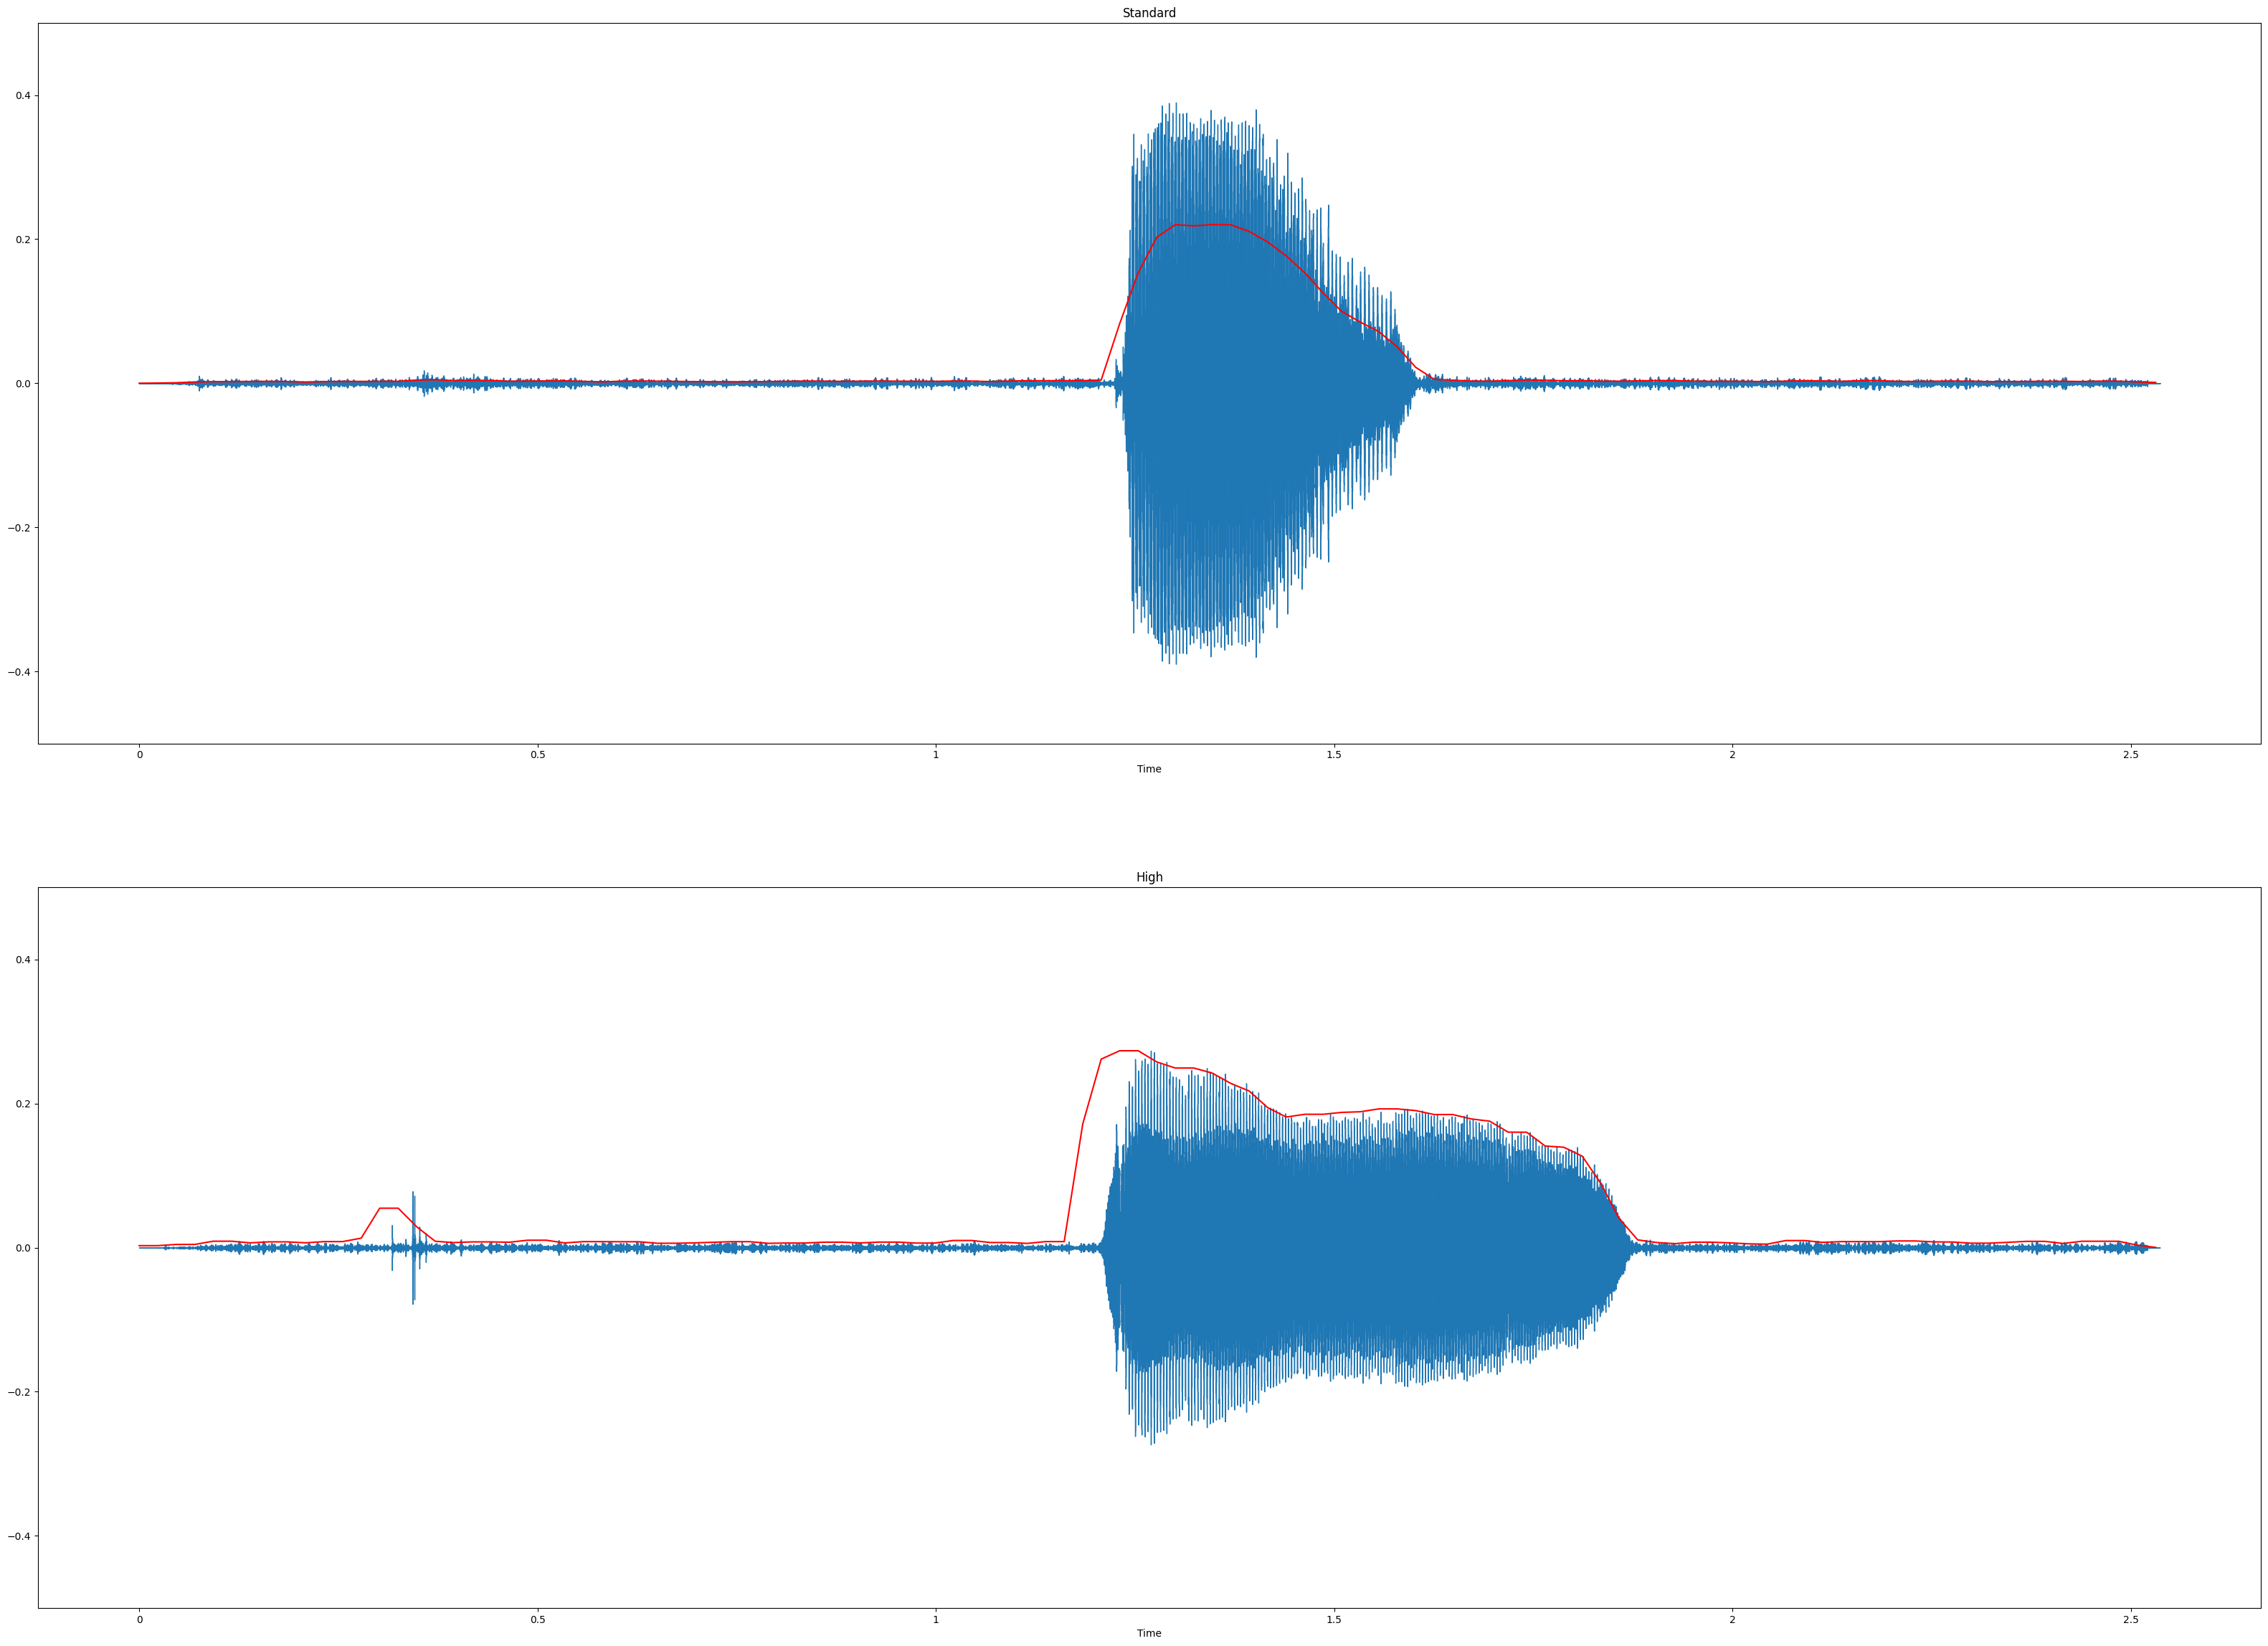

In [21]:
# amplitude envelope is graphed in red

plt.figure(figsize=(40, 60))

ax = plt.subplot(4, 1, 1)
librosa.display.waveshow(signal_standard)
plt.plot(t, rms_standard, color="r")
plt.ylim((-0.5, 0.5))
plt.title("Standard")

plt.subplot(4, 1, 2)
librosa.display.waveshow(signal_high)
plt.plot(t, ae_high, color="r")
plt.ylim((-0.5, 0.5))
plt.title("High")

# plt.subplot(4, 1, 3)
# librosa.display.waveshow(signal_low)
# plt.plot(t, ae_low, color="r")
# plt.ylim("low")

# plt.subplot(4, 1, 4)
# librosa.display.waveshow(signal_wrong)
# plt.plot(t, ae_wrong, color="r")
# plt.ylim("wrong")

plt.show()


#### extract mfccs


In [22]:
standard = librosa.feature.mfcc(y=signal_standard, n_mfcc=1, sr=sr_standard)
high = librosa.feature.mfcc(y=signal_high, n_mfcc=1, sr=sr_high)
low = librosa.feature.mfcc(y=signal_low, n_mfcc=1, sr=sr_low)
wrong = librosa.feature.mfcc(y=signal_wrong, n_mfcc=1, sr=sr_wrong)
standard.shape, high.shape, low.shape, wrong.shape

((1, 110), (1, 110), (1, 112), (1, 99))


(
    np.float64(-5.550000000000001),
    np.float64(116.55),
    np.float64(-1285.9785614013672),
    np.float64(404.33250427246094)
)

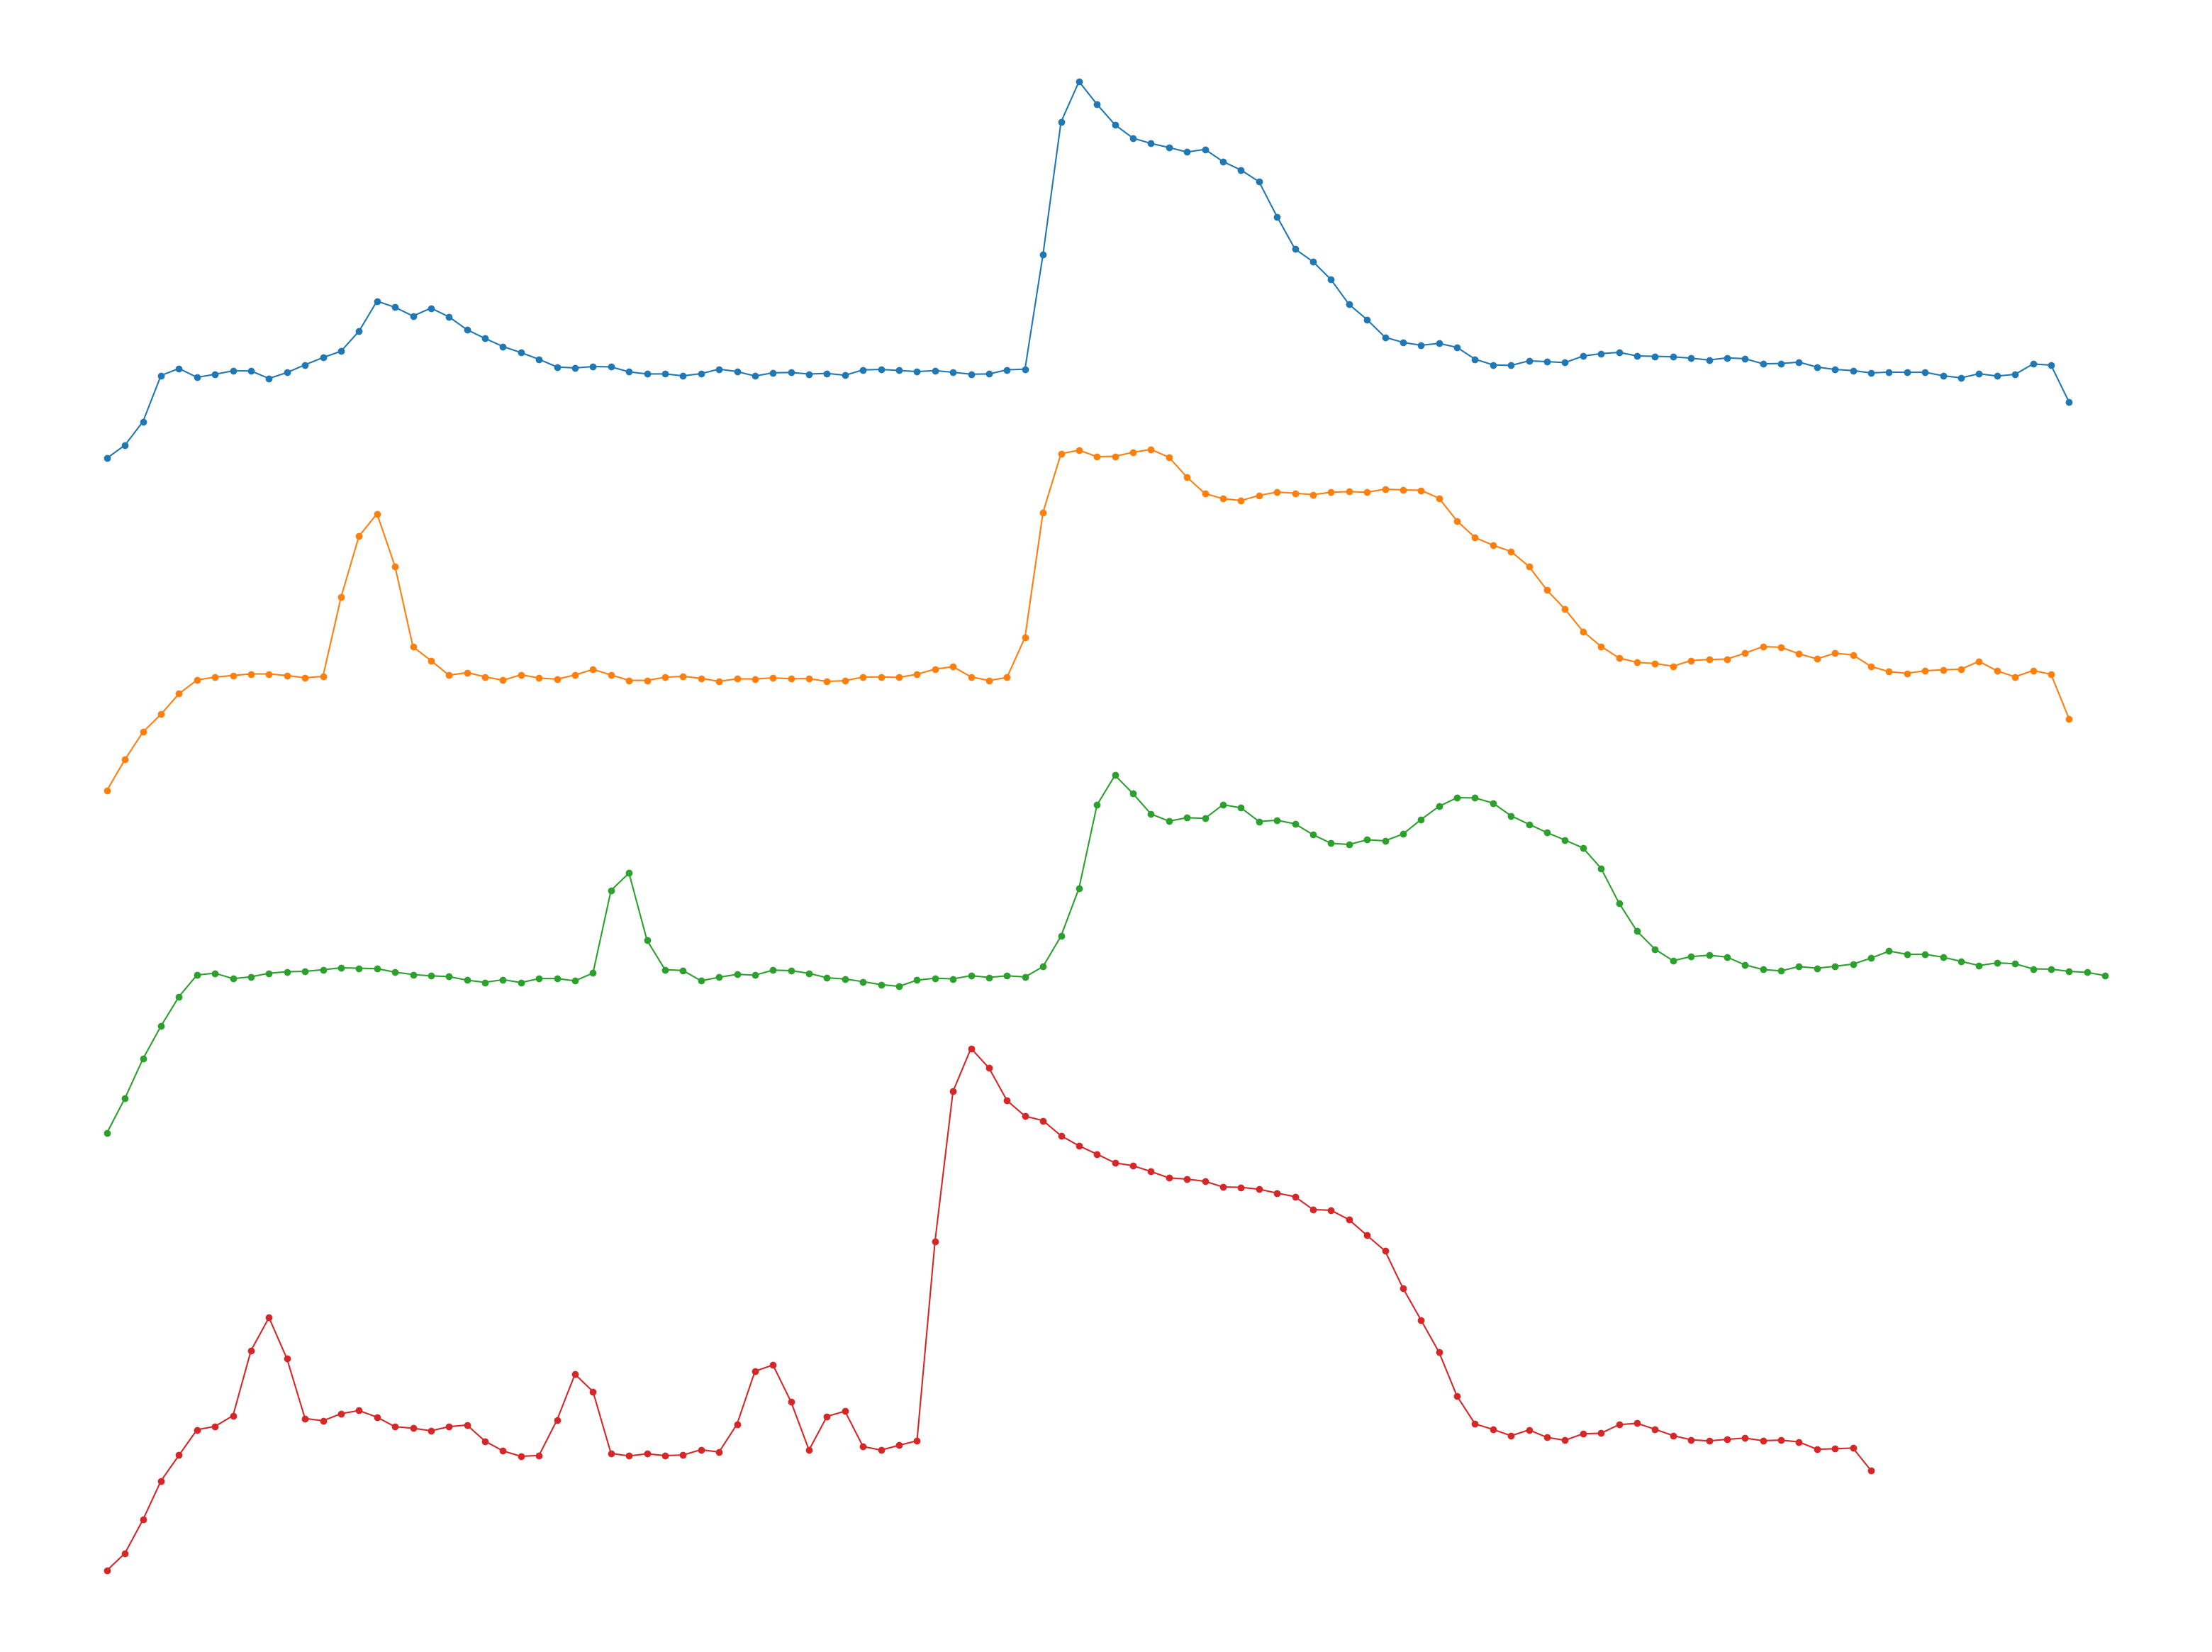

In [23]:
x_standard = np.array(standard)[0]
y_high = np.array(high)[0]
y_low = np.array(low)[0]
y_wrong = np.array(wrong)[0]

plt.figure(figsize=(40, 30))
plt.plot(np.arange(x_standard.shape[0]), x_standard + 500, "-o", c="C0")
plt.plot(np.arange(y_high.shape[0]), y_high + 200, "-o", c="C1")
plt.plot(np.arange(y_low.shape[0]), y_low - 100, "-o", c="C2")
plt.plot(np.arange(y_wrong.shape[0]), y_wrong - 600, "-o", c="C3")
plt.axis("off")

In [24]:
for curr in [y_high, y_low, y_wrong]:
    # distance matrix
    N = x_standard.shape[0]
    M = curr.shape[0]
    dist_mat = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            dist_mat[i, j] = abs(x_standard[i] - curr[j])

    # dtw
    path, cost_mat = dp(dist_mat)
    print("Alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]))
    print("Normalized alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1] / (N + M)))
    print()

Alignment cost: 1771.9070
Normalized alignment cost: 8.0541

Alignment cost: 2859.2517
Normalized alignment cost: 12.8795

Alignment cost: 1768.8802
Normalized alignment cost: 8.4635

